# Synthetic Control - parameter recovery

This notebook shows an example of running Bayesian synthetic control on some synthetic data.

In [1]:
from causal_impact.causal_impact import SyntheticControl
from causal_impact.simulate_data import generate_synthetic_control_data

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Generate simulated dataset

In [4]:
treatment_time = 70
df, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,-0.431202,0.678363,-0.741883,-2.166627,0.428841,1.491113,1.079639,-0.134105,0.0,-0.701028
1,0.759615,1.766584,-0.802995,-1.279839,0.618006,1.687649,1.386720,0.251895,0.0,0.757220
2,1.600318,1.429493,-0.466537,-0.465952,0.750496,1.216423,1.391715,0.640110,0.0,0.678865
3,2.277220,1.291286,-0.383417,0.050988,0.920503,1.048549,2.225320,1.030905,0.0,0.977477
4,2.845648,2.191943,-0.016849,0.727631,1.311293,1.228403,2.672127,1.423939,0.0,1.319064


Create some useful visualisations

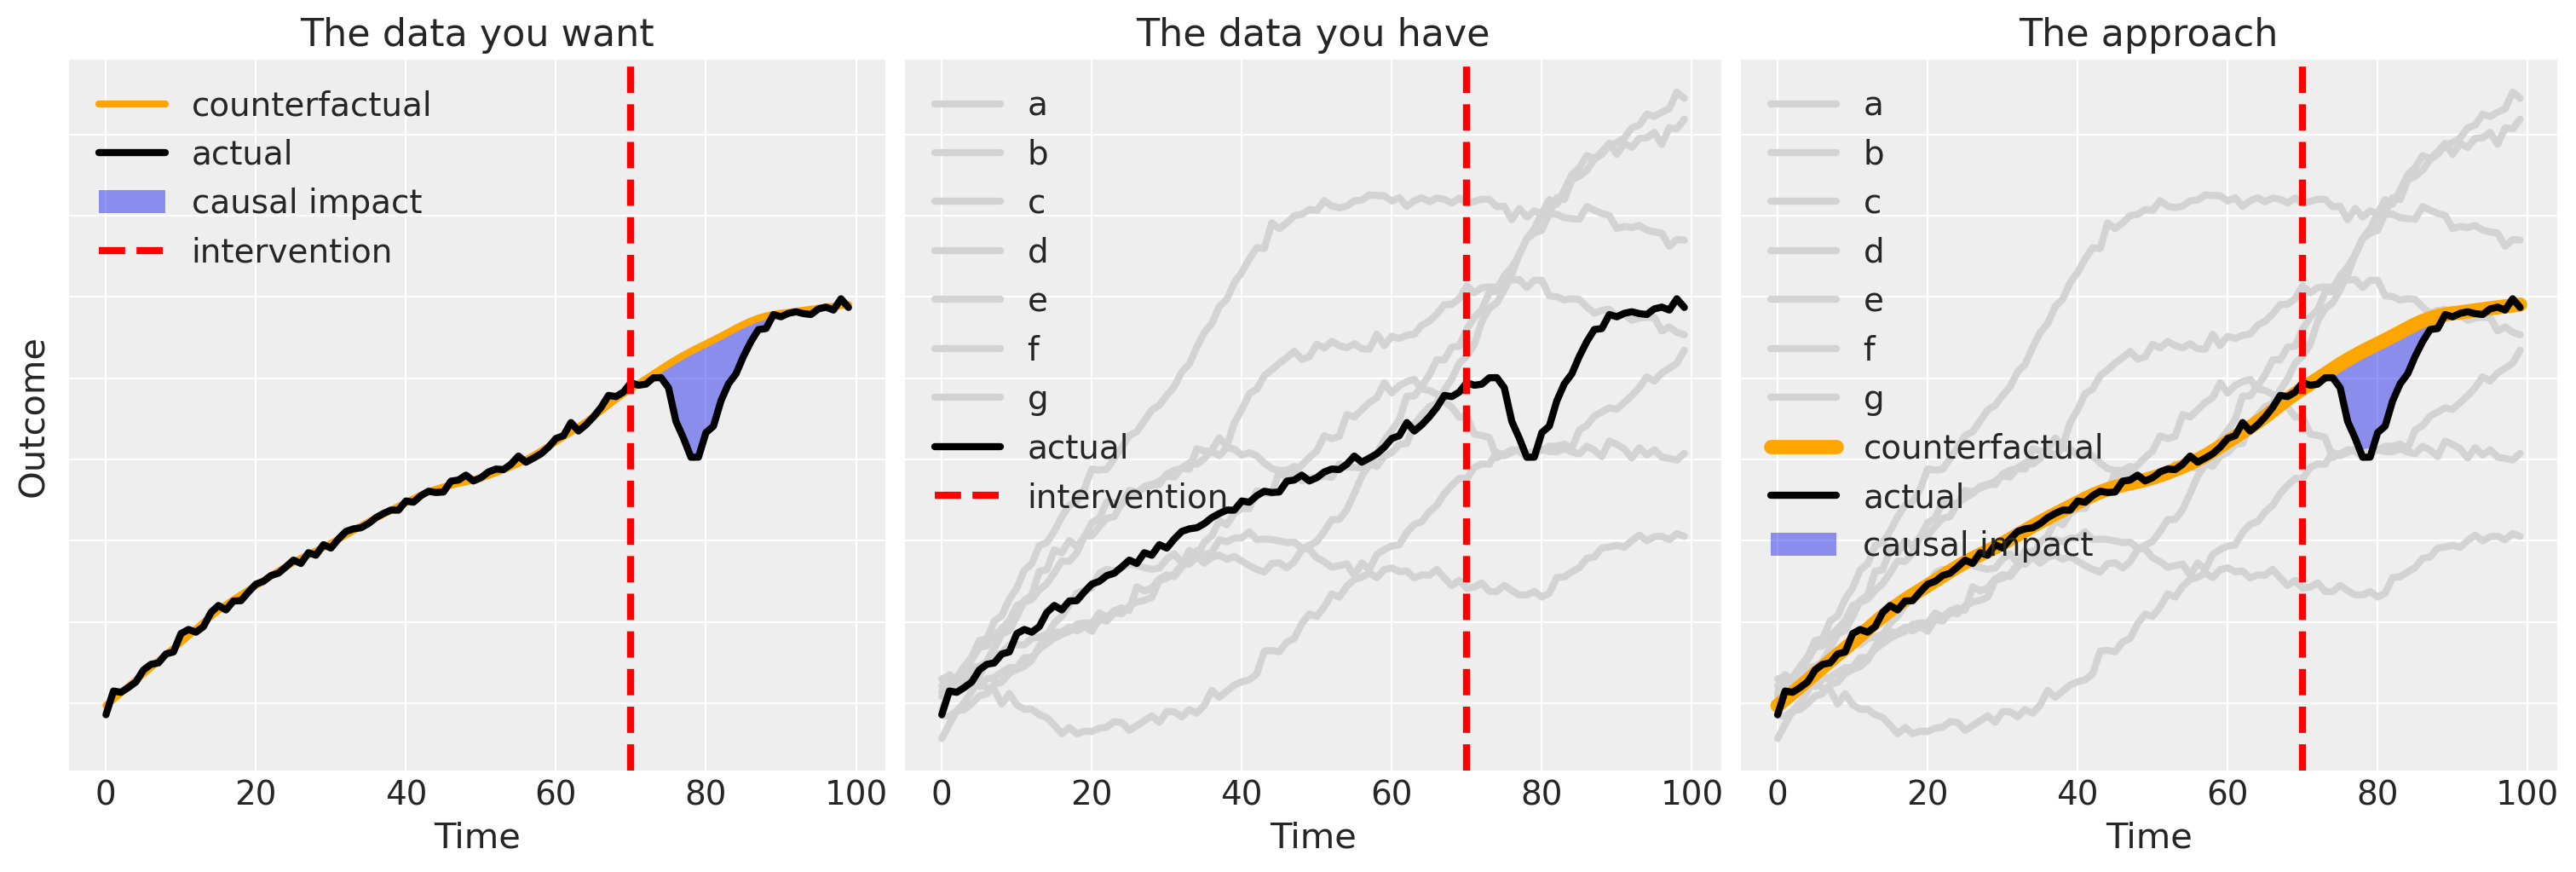

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# WHAT YOU WANT
df.loc[:, ['counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[0])
df.loc[:, ['actual']].plot(c='k', ax=ax[0], lw=3)
ax[0].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
ax[0].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The data you want')
ax[0].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[0].legend()

# WHAT YOU HAVE
df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3, ax=ax[1])
df.loc[:, ['actual']].plot(c='k', ax=ax[1], lw=3)
ax[1].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The data you have')
ax[1].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention',)
ax[1].legend();

# THE APPROACH
df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3, ax=ax[2])
df.loc[:, ['counterfactual']].plot(c='orange', ax=ax[2], lw=6, ls="-")
df.loc[:, ['actual']].plot(c='k', ax=ax[2], lw=3)
ax[2].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
ax[2].set(xlabel="Time", ylabel="Outcome", yticklabels=[], title='The approach')
ax[2].axvline(x=treatment_time, linewidth=3, c='r', ls='--')
ax[2].legend();

## Bayesian synthetic control

See if we can infer the causal impact accurately by estimating a synthetic control

In [6]:
result = SyntheticControl(df, 
                          treatment_date=treatment_time, 
                          target_var="actual",
                          predictor_vars=['a', 'b', 'c', 'd', 'e', 'f', 'g'])

PRIOR PREDICTIVE CHECK
INFERENCE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.


POSTERIOR PREDICTIVE CHECK


COUNTERFACTUAL INFERENCE


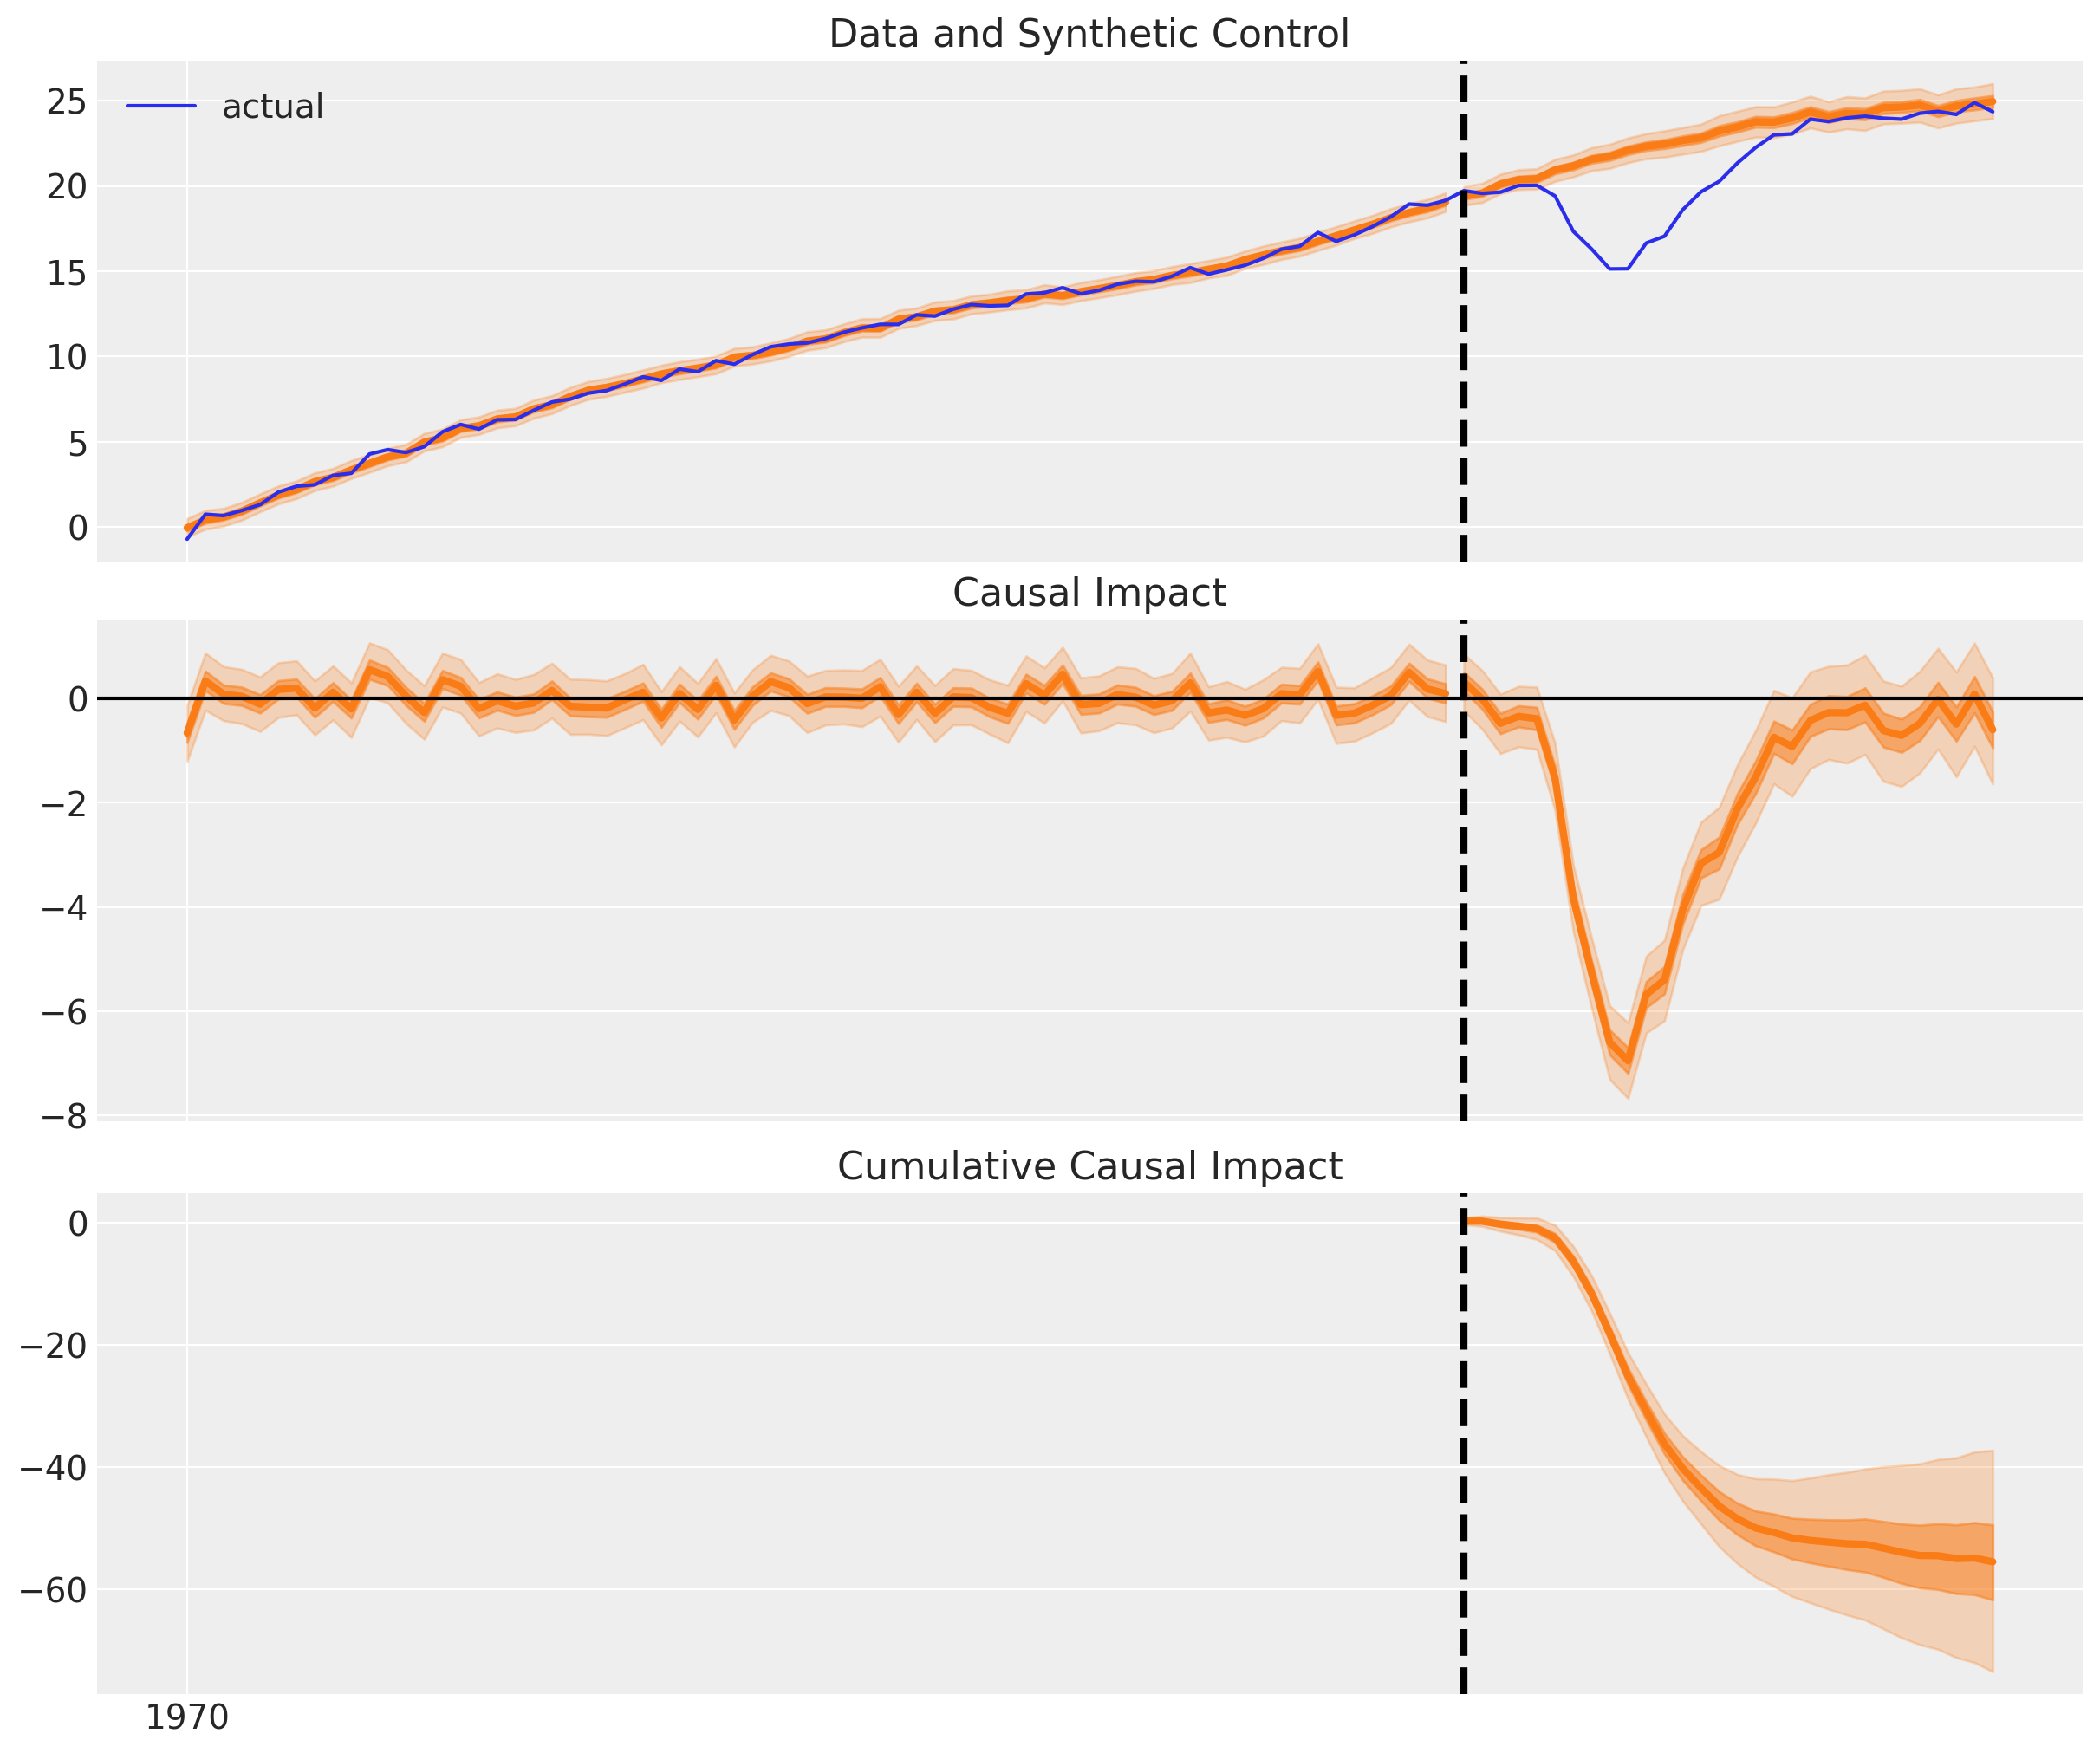

In [7]:
result.plot()

Visualise the posterior distributions of the variable weightings.

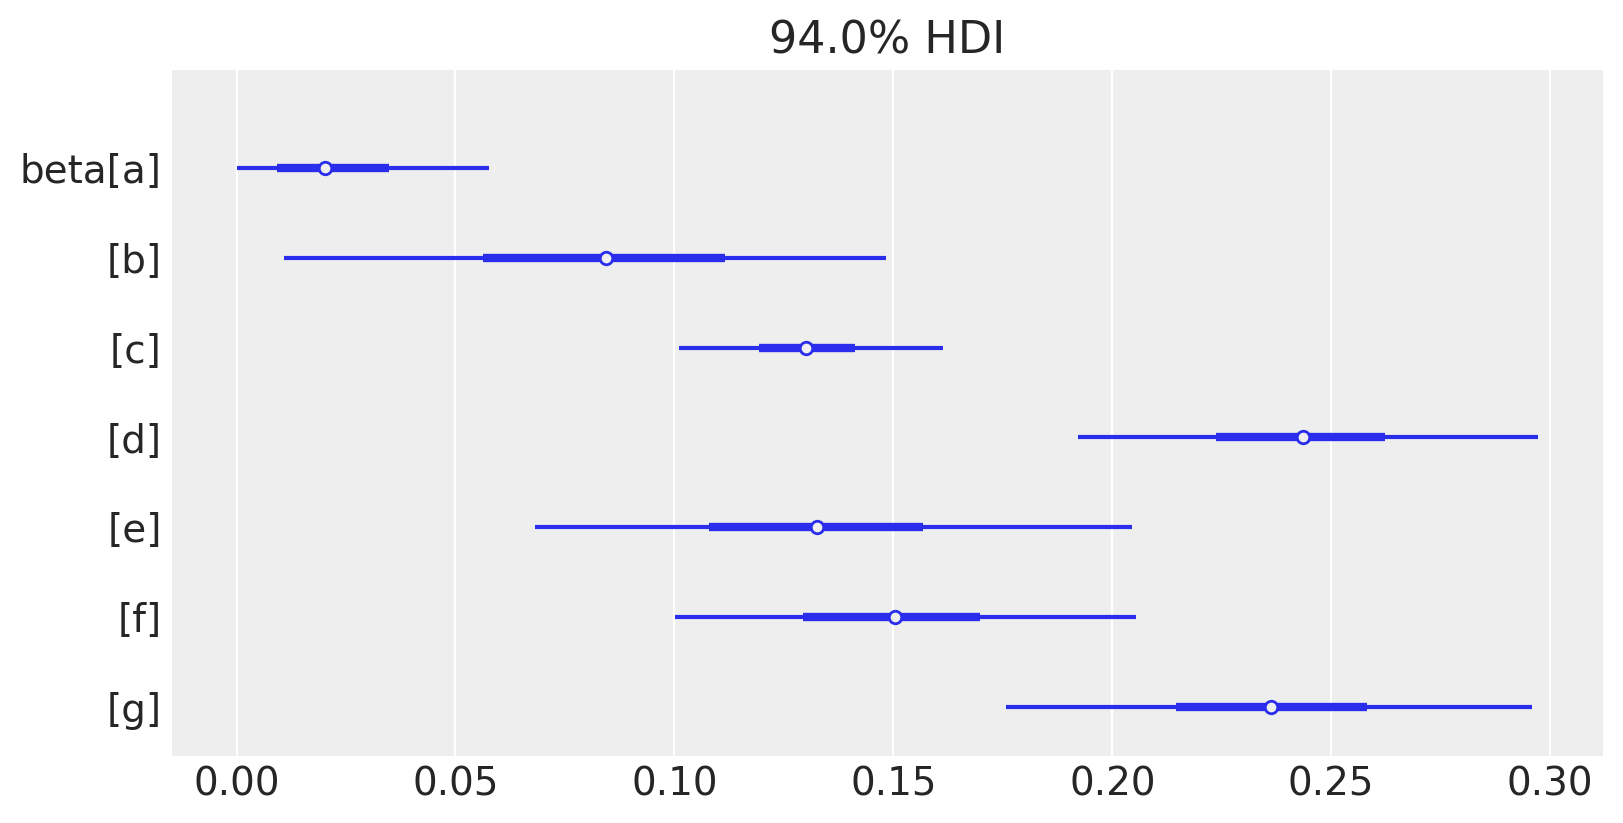

In [8]:
az.plot_forest(result.idata_pre.posterior, var_names="beta", figsize=(8, 4), combined=True);

A similar plot of the posterior distributions of variable weightings, but this time with ground truth of the simulated data.

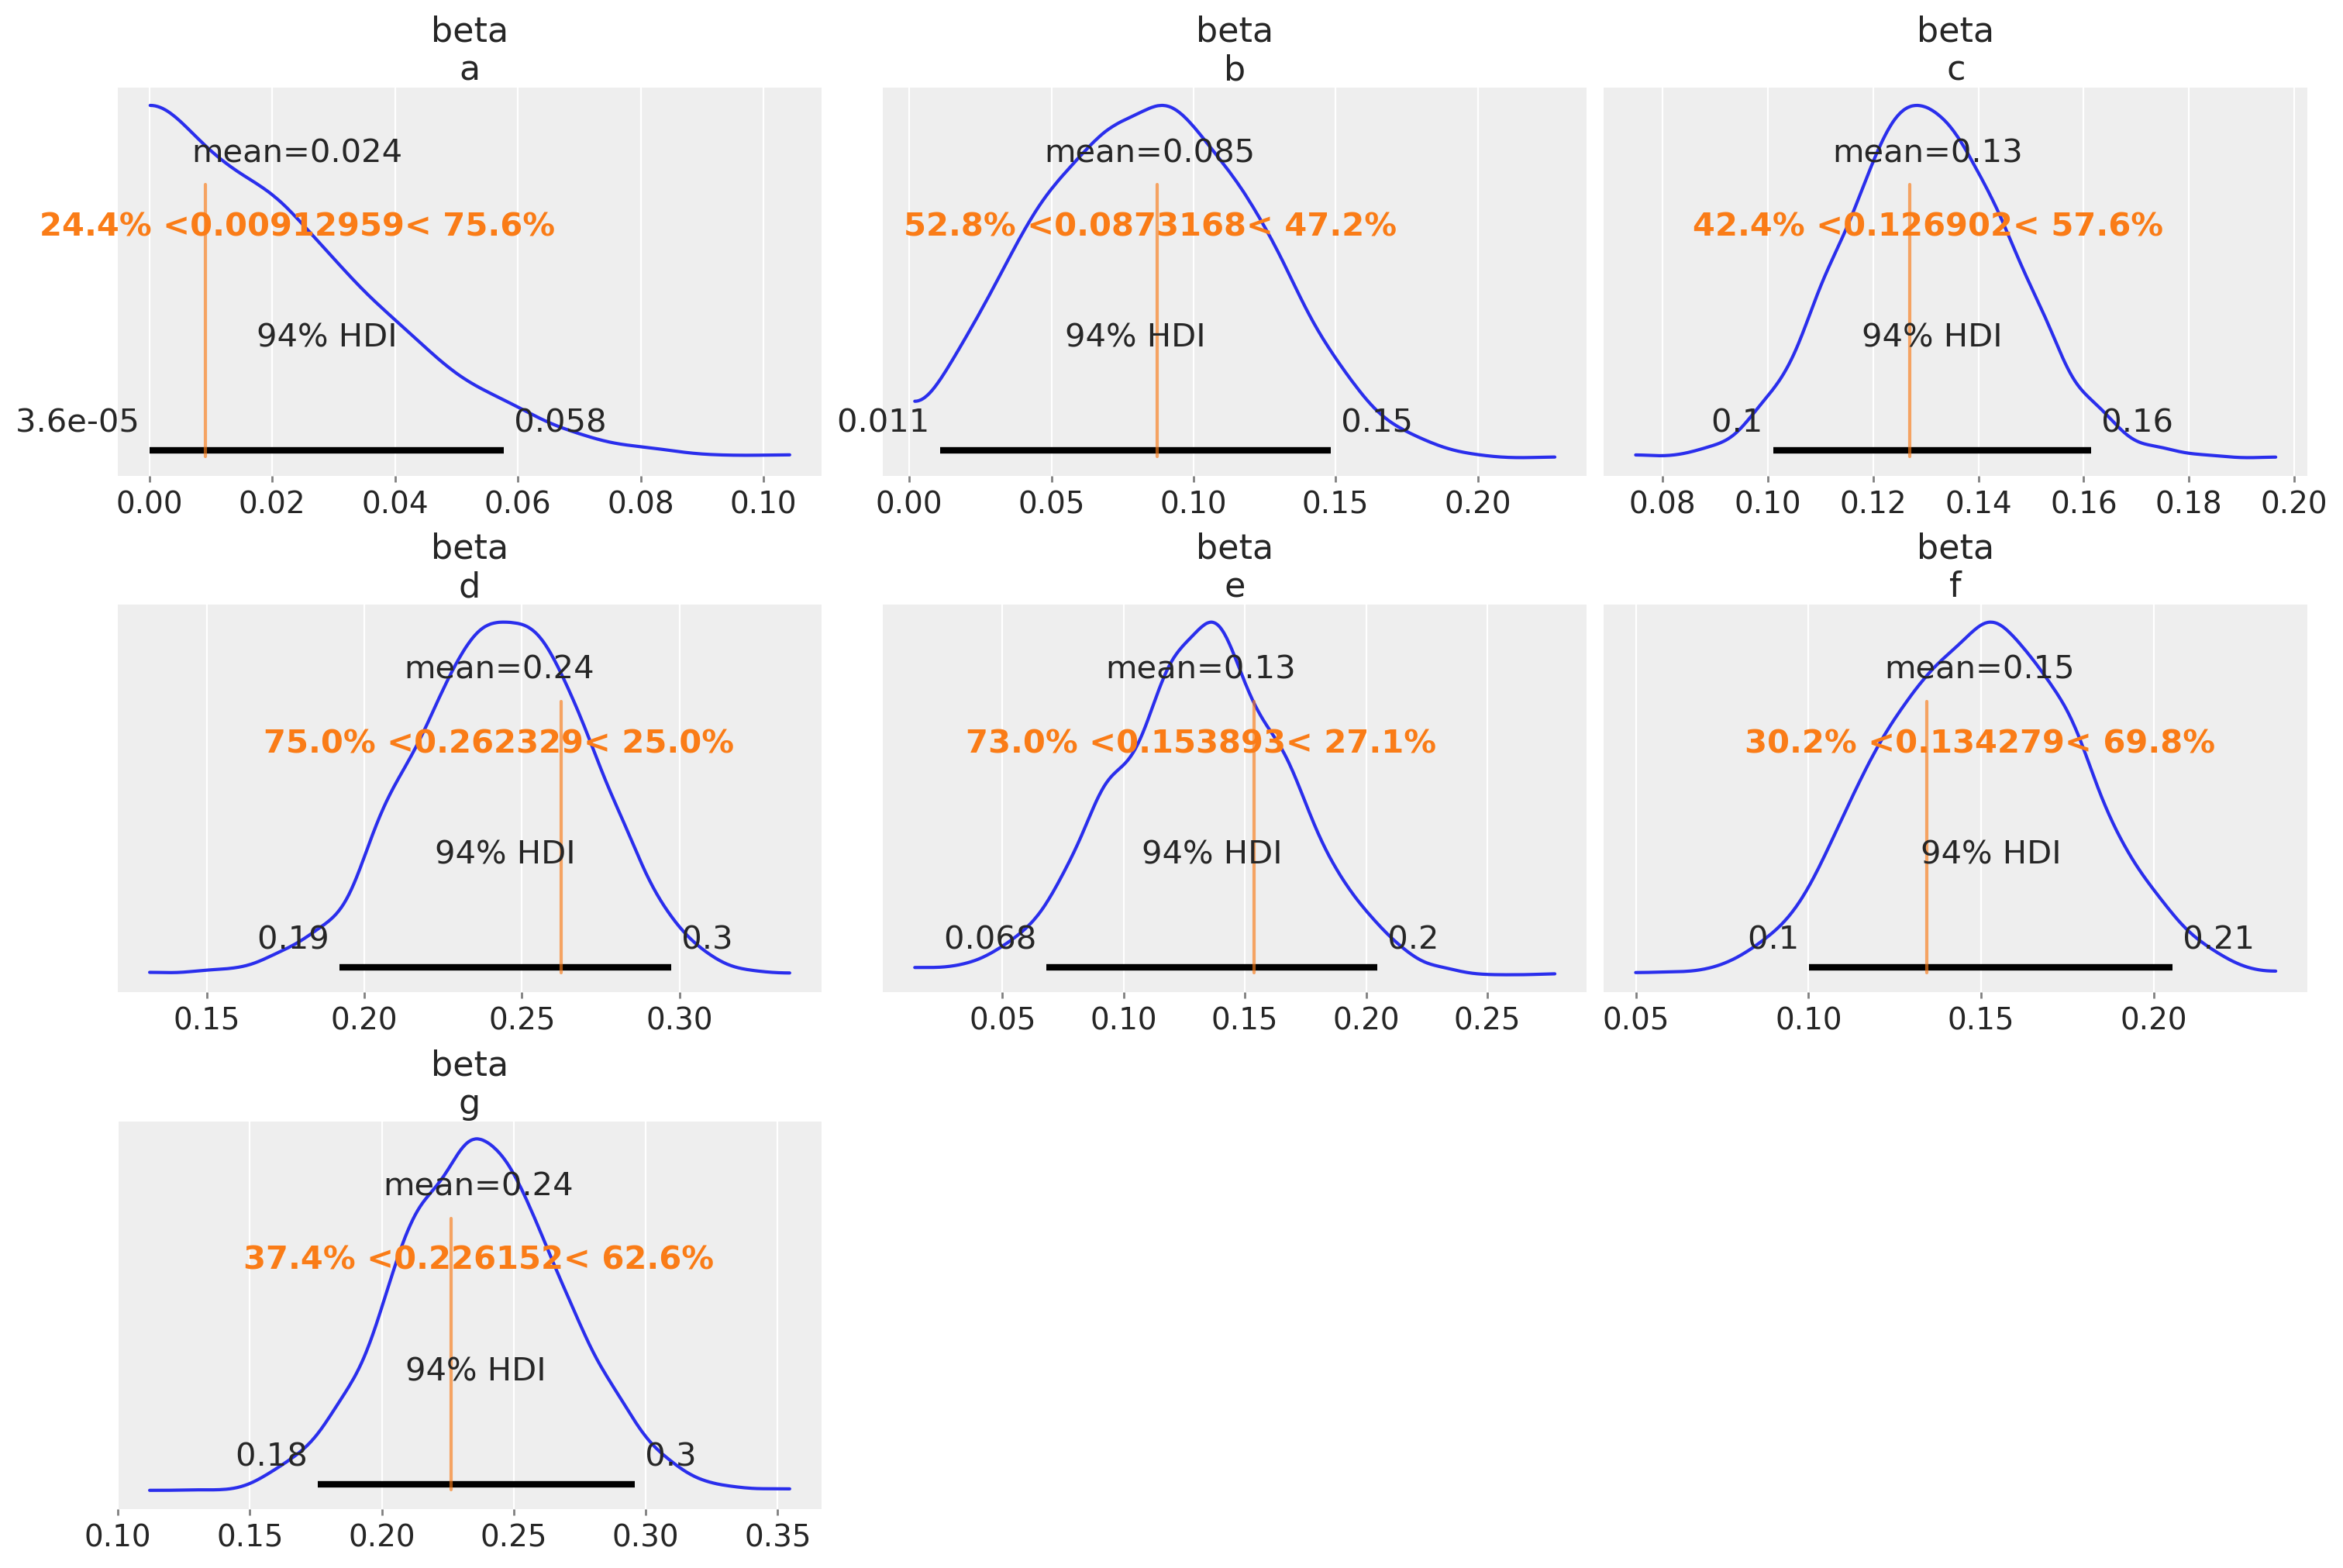

In [9]:
ref_val = {"beta": [{"predictors": "a", "ref_val": weightings_true[0][0]},
                    {"predictors": "b", "ref_val": weightings_true[0][1]},
                    {"predictors": "c", "ref_val": weightings_true[0][2]},
                    {"predictors": "d", "ref_val": weightings_true[0][3]},
                    {"predictors": "e", "ref_val": weightings_true[0][4]},
                    {"predictors": "f", "ref_val": weightings_true[0][5]},
                    {"predictors": "g", "ref_val": weightings_true[0][6]}]}

az.plot_posterior(result.idata_pre.posterior['beta'], ref_val=ref_val, figsize=(15, 10));